In [1]:
import os
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

from model_architectures import DDPM
from data_loaders_l import SynthesisDataModule


In [3]:
with open('config_l.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = os.path.join(config['model_dir'], 'ddpm-epoch=29-train_loss=0.1283.ckpt')

model = DDPM.load_from_checkpoint(
    checkpoint_path,
    label_dim=config['label_dim'],
    learning_rate=0
)
model.eval().to('cuda' if torch.cuda.is_available() else 'cpu')


DDPM(
  (model): DenoiseModel(
    (label_embedding): Embedding(4, 256)
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): ReLU()
    )
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): SiLU()
  )
)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(torch.float32))
])

data_module = SynthesisDataModule(batch_size=1, transform=transform)
data_module.setup()

img_tensor, label_tensor = next(iter(data_module.train_dataloader()))
img_tensor, label_tensor = img_tensor.to(model.device), label_tensor.to(model.device)

print("Using label:", label_tensor.item())


Using label: 3


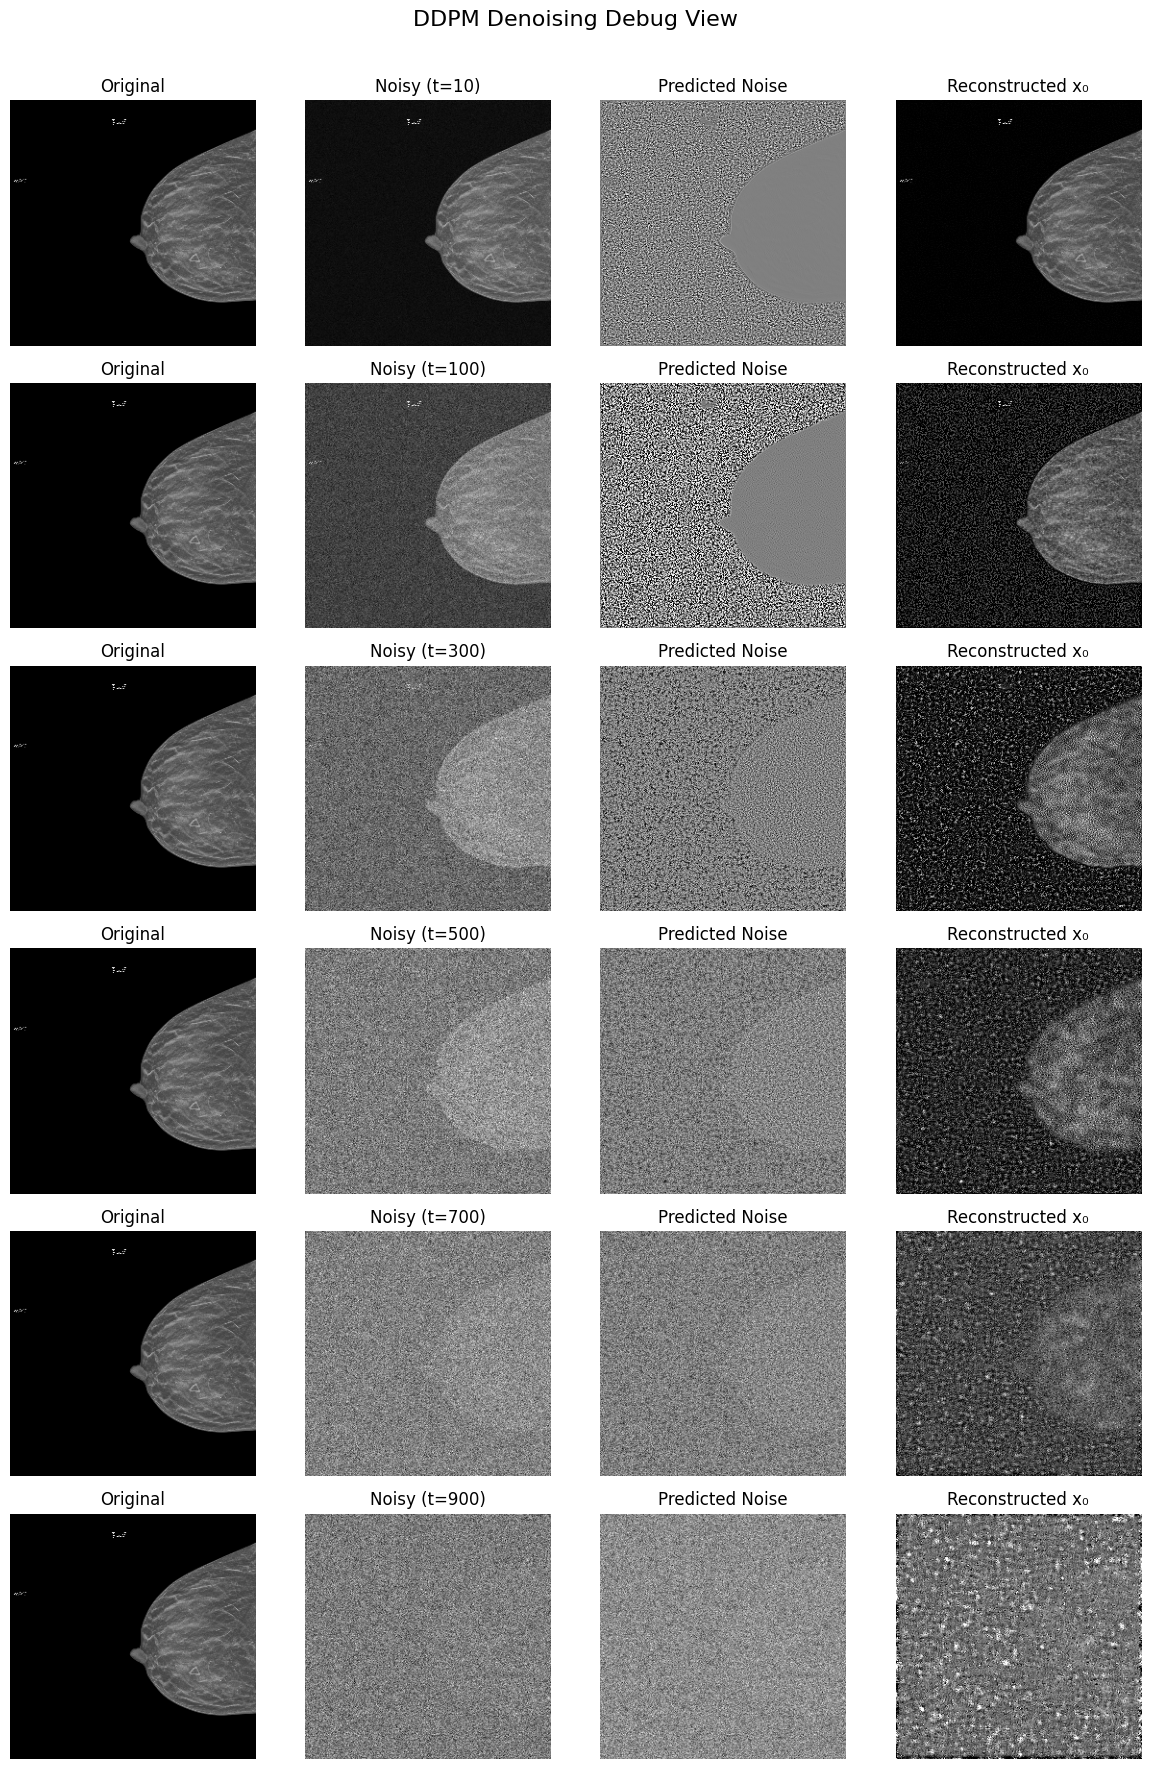

In [7]:
timesteps_to_debug = [10, 100, 300, 500, 700, 900]
fig, axs = plt.subplots(len(timesteps_to_debug), 4, figsize=(12, 3 * len(timesteps_to_debug)))
fig.suptitle("DDPM Denoising Debug View", fontsize=16)

for i, t_val in enumerate(timesteps_to_debug):
    t = torch.tensor([t_val], device=img_tensor.device)
    
    noise = torch.randn_like(img_tensor)
    sqrt_alpha_hat = torch.sqrt(model.alpha_hat[t_val]).to(img_tensor.device)
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - model.alpha_hat[t_val]).to(img_tensor.device)

    x_t = sqrt_alpha_hat * img_tensor + sqrt_one_minus_alpha_hat * noise

    # Get model prediction
    predicted_noise = model(x_t, t, label_tensor)
    x0_pred = (x_t - sqrt_one_minus_alpha_hat * predicted_noise) / sqrt_alpha_hat
    x0_pred = torch.clamp(x0_pred, -1, 1)

    def to_numpy(img):
        return img.detach().cpu().squeeze().numpy()

    axs[i, 0].imshow(to_numpy(img_tensor), cmap='gray')
    axs[i, 0].set_title("Original")

    axs[i, 1].imshow(to_numpy(x_t), cmap='gray')
    axs[i, 1].set_title(f"Noisy (t={t_val})")

    axs[i, 2].imshow(to_numpy(predicted_noise), cmap='gray')
    axs[i, 2].set_title("Predicted Noise")

    axs[i, 3].imshow(to_numpy(x0_pred), cmap='gray')
    axs[i, 3].set_title("Reconstructed x₀")

    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])

save_path = "./plots/timestep_denoising_debug.png"
plt.savefig(save_path)
plt.show()


# Let's do both guided and unguided for comparison

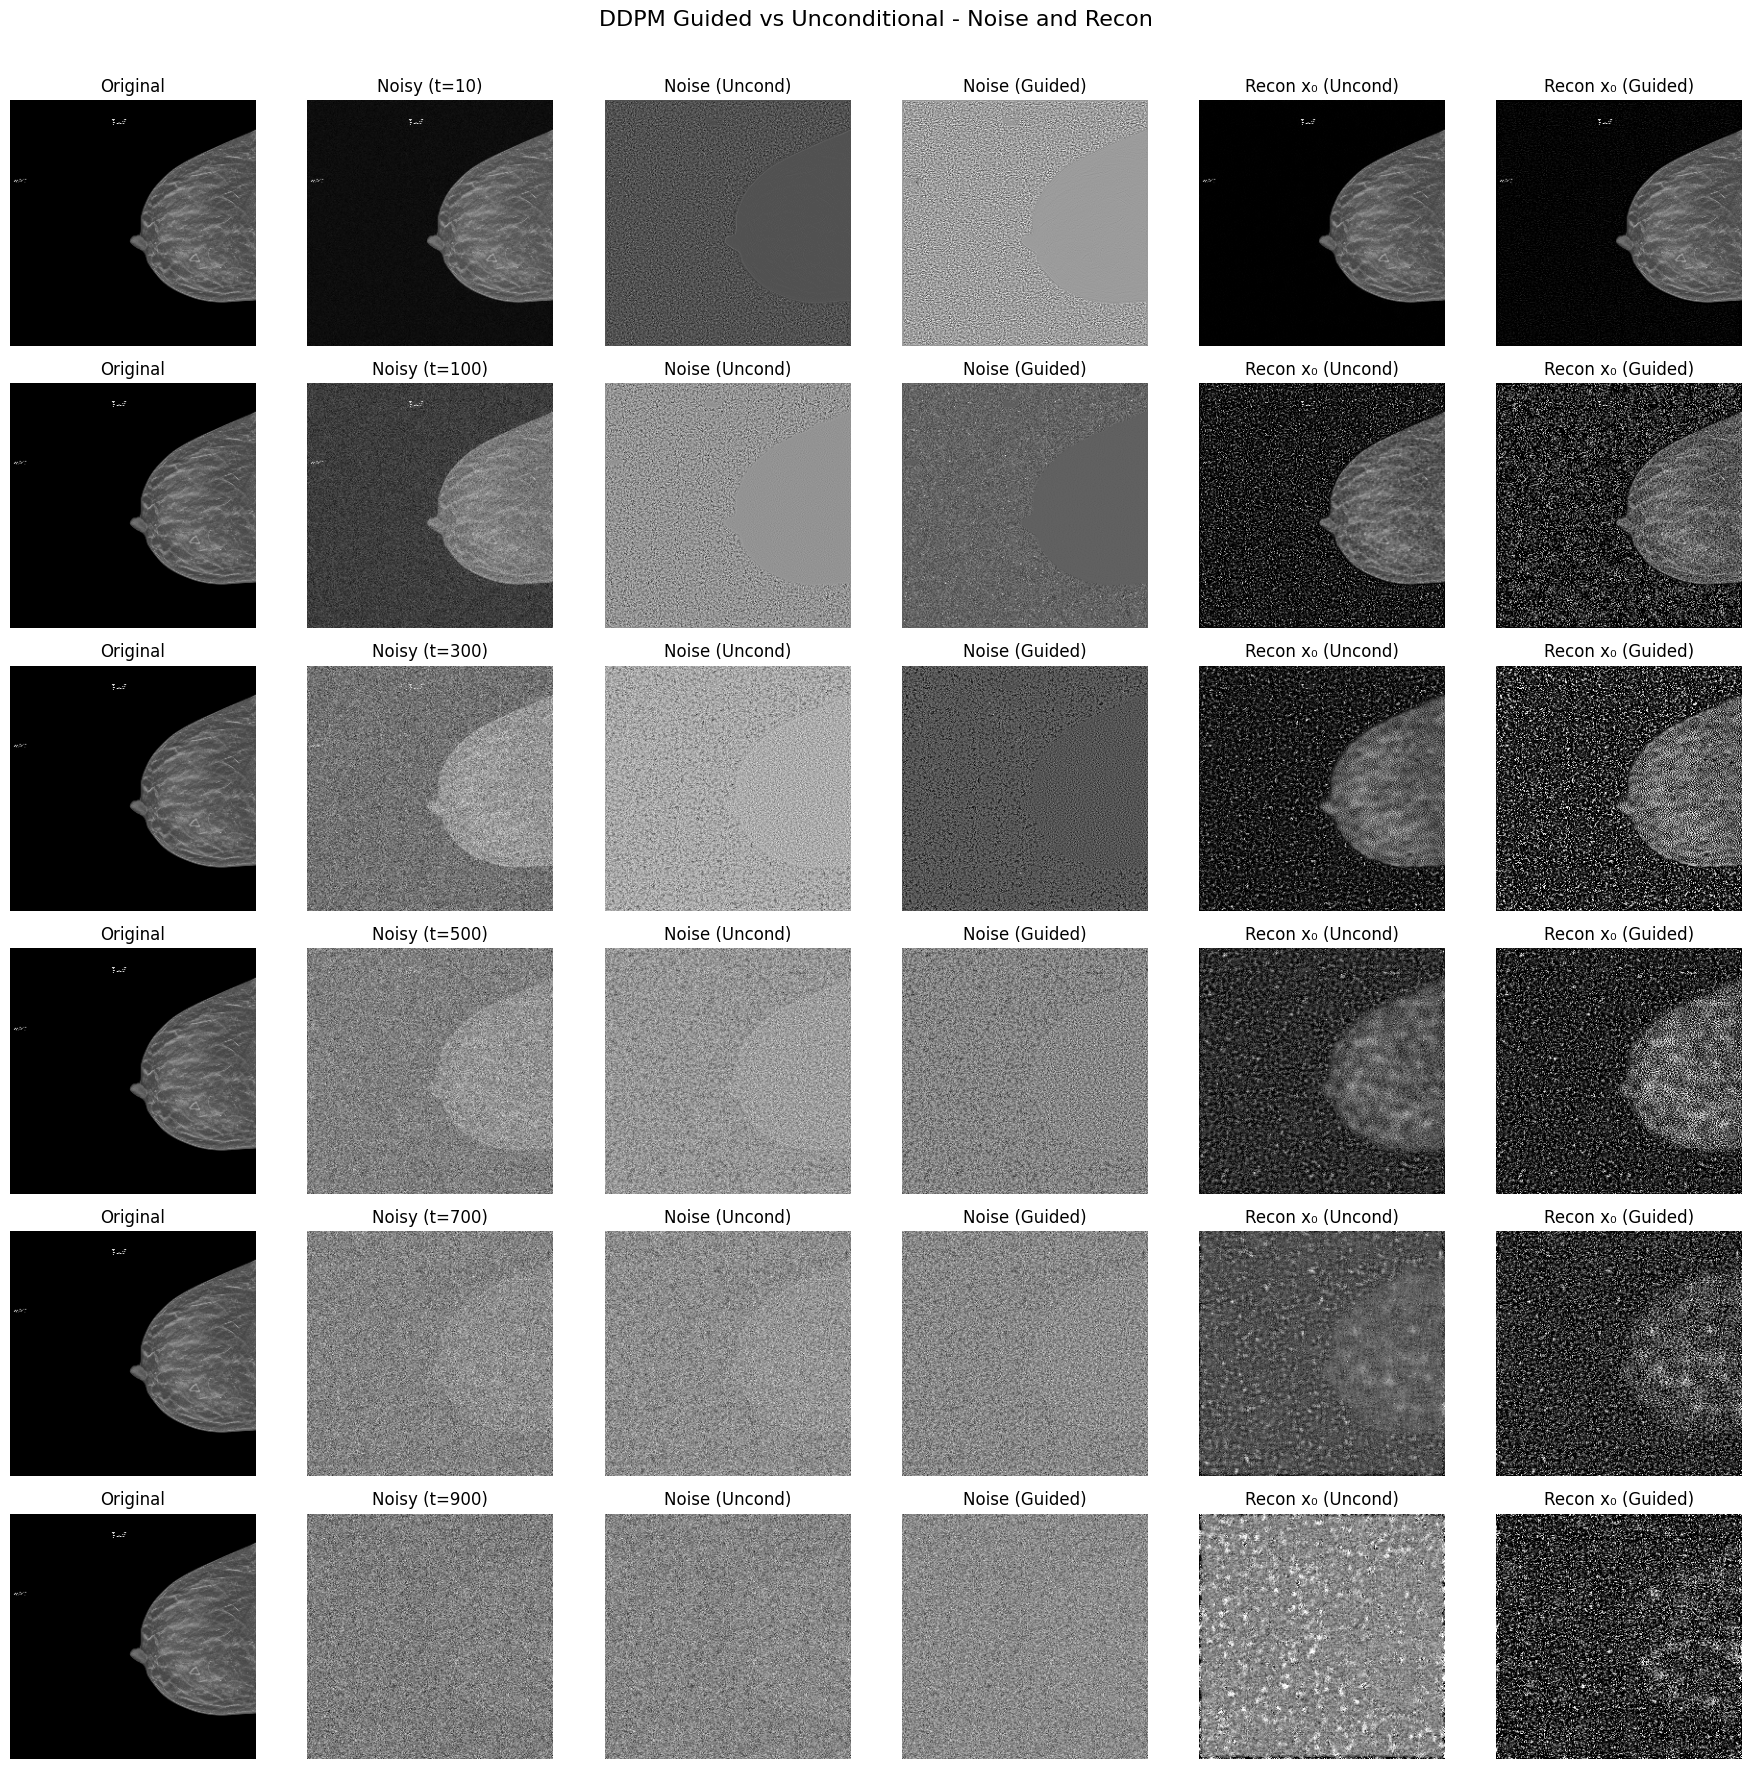

In [12]:
timesteps_to_debug = [10, 100, 300, 500, 700, 900]
fig, axs = plt.subplots(len(timesteps_to_debug), 6, figsize=(18, 3 * len(timesteps_to_debug)))
fig.suptitle("DDPM Guided vs Unconditional - Noise and Recon", fontsize=16)

for i, t_val in enumerate(timesteps_to_debug):
    t = torch.tensor([t_val], device=img_tensor.device)
    label = label_tensor
    uncond_label = -1 * torch.ones_like(label)

    noise = torch.randn_like(img_tensor)
    sqrt_alpha_hat = torch.sqrt(model.alpha_hat[t_val]).to(img_tensor.device)
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - model.alpha_hat[t_val]).to(img_tensor.device)
    x_t = sqrt_alpha_hat * img_tensor + sqrt_one_minus_alpha_hat * noise

    # Predict noise - unguided
    pred_noise_uncond = model(x_t, t, uncond_label)
    x0_uncond = (x_t - sqrt_one_minus_alpha_hat * pred_noise_uncond) / sqrt_alpha_hat
    x0_uncond = torch.clamp(x0_uncond, -1, 1)

    # Predict noise - guided
    pred_noise_cond = model(x_t, t, label)
    guidance_scale = model.guidance_scale
    pred_noise_guided = pred_noise_uncond + guidance_scale * (pred_noise_cond - pred_noise_uncond)
    x0_guided = (x_t - sqrt_one_minus_alpha_hat * pred_noise_guided) / sqrt_alpha_hat
    x0_guided = torch.clamp(x0_guided, -1, 1)

    def to_numpy(img):
        return img.detach().cpu().squeeze().numpy()

    axs[i, 0].imshow(to_numpy(img_tensor), cmap='gray')
    axs[i, 0].set_title("Original")

    axs[i, 1].imshow(to_numpy(x_t), cmap='gray')
    axs[i, 1].set_title(f"Noisy (t={t_val})")

    axs[i, 2].imshow(to_numpy(pred_noise_uncond), cmap='gray')
    axs[i, 2].set_title("Noise (Uncond)")

    axs[i, 3].imshow(to_numpy(pred_noise_guided), cmap='gray')
    axs[i, 3].set_title("Noise (Guided)")

    axs[i, 4].imshow(to_numpy(x0_uncond), cmap='gray')
    axs[i, 4].set_title("Recon x₀ (Uncond)")

    axs[i, 5].imshow(to_numpy(x0_guided), cmap='gray')
    axs[i, 5].set_title("Recon x₀ (Guided)")

    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()